# CS156: Machine Learning for Science and Profit

### Prof. Watson 11a T/Th Class
#### Isabel Brunkan
#### Jupyter Notebook available here: \
https://gist.github.com/ibrisa/b4c4a6cab8d4d74d0a58e5add8b0eebb

# CS156 Final Project: Movie Sentiment Analysis

## Introduction

Natural Language Processing is an area of Machine Learning that is fascinating because of its wide spread applicability and in the area of sentiment analysis, the ability to extract emotions from a sentence, something even humans sometimes fail to do. As day by day, more communication is replaced with text instead of conversations, text analysis and NLP's role can grow even larger.
     
In this assignment, I use the [IMDB Dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) obtained from Kaggle, which contains 50,000 movie reviews of which there are an equal amount of negative or positive polarizing reviews. The goal of this assignment is two-fold, obtain the highest classification accuracy by testing a variety of models while also testing different stemming and lemmatization methods to see how this can influence the classification accuracy.     

As NLP deals with text, the same word might be used a variety of times inflected in different forms (e.g. befuddle, befuddled, befuddling) which are called a lexeme. Ideally, the algorithm should treat all of the occurrences of that word as the same word (e.g. befuddle), or the base word that you would find in the dictionary, also called the lemma (hence lemmatization). There are many options to translate the inflections into a single word - lemmatization techniques find the lemma, while stemming techniques find the part of the word that is responsible for its lexical meaning, which can often result in truncated looking words. In this assignment, I test the following stemming and lemmatization techniques:
- Snowball Stemmer
- Lancaster Stemmer
- Word Net Lemmatizer
- SpaCy's Lemmatizer

For the model section of this assignment, I test each of the stemming/lemmatization techniques on:
- a simple neural network 
- a convolutional neural network
- a recurrent neural network with LSTM


## Data Loading and Pre Processing

The first step is to load the data and conduct some initial data analysis to see the nature of the data.

    
    
For spacy, we need to download the en_core_web_sm and to run LTSM, we need to roll back numpy to version 1.19.5 according to a Github issue.

In [1]:
import sys
!{sys.executable} -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [3]:
# The Essentials
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import spacy
import nltk
import re

# Model Specific
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, LSTM
from keras.layers.core import Activation, Dropout, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from sklearn.model_selection import KFold
from keras.models import Sequential

# NLTK
from nltk import LancasterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Numpy 
from numpy import array
from numpy import asarray
from numpy import zeros

# Word Cloud Related
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

sp = spacy.load('en_core_web_sm')

In [15]:
# Load the data and take a look at how it's composed
movies = pd.read_csv("IMDB Dataset.csv")

print('Checking if there are NA:', movies.isnull().values.any())

print("There are {} observations and {} features in this dataset. \n".format(movies.shape[0],movies.shape[1]))

Checking if there are NA: False
There are 50000 observations and 2 features in this dataset. 



In [16]:
# preview the first few and last few entries
movies

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [17]:
movies[:30].to_csv('Shortened_Movie.csv', sep=',')

<AxesSubplot:xlabel='sentiment', ylabel='count'>

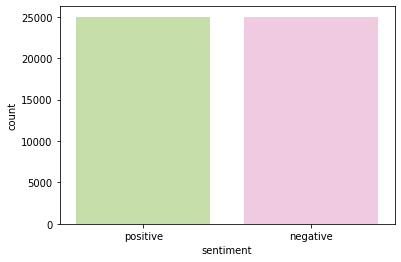

In [6]:
sns.countplot(x = 'sentiment', data = movies, palette='PiYG_r')

As we can see above, this dataset has an equal amount of reviews with the sentiment coded as positive or negative.

### Data Cleaning
Before proceeding to run the model, it's important to perform data cleaning to ensure there are no undesired characters that could influence the model and provide conclusions that have no merit. For example, as seen below, there are some HTML characters like the symbol for 'break' which are irrelevant to the review. The next step is to remove these.

In [7]:
print(movies['review'][0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [8]:
# adapted from: https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
def clean_txt(sentence):
    # get rid of all the symbols that aren't relevant to the movie review
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}#x[0-9a-f]{1,6});')
    clean_sen = re.sub(cleanr, '', sentence)
    
    return clean_sen

In [9]:
X = []
sentences = list(movies['review'])

# clean each of the reviews in the dataframe
for sen in sentences: 
    X.append(clean_txt(sen))
    
movies['clean'] = X
movies

,review,sentiment,clean
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,I'm going to have to disagree with the previou...


In [10]:
print(X[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wou

In [14]:
movies['clean'].to_csv('cleaned_movie.csv', sep=',')

As we can see above, all of the HTML specific characters are now removed from the movie review. 

## Initial Analysis

Now that the dataset has undergone the most basic of cleaning, we can look at a few summary statistics to get a sense of what the dataset is like, before progressing to building the model and tokenizing the data. We can look at the word count for each review and the punctuation (e.g. !) to see if this differs between positive and negative reviews.

In [11]:
# find the word count of each review, and check whether there is any punctuation (e.g. !)
movies['Word_Count'] = [len(review.split()) for review in movies['clean']]
movies['punc'] = [sum(char in string.punctuation for char in review) \
                            for review in movies['clean']]

movies

,review,sentiment,clean,Word_Count,punc
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,301,60
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...,156,26
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,162,28
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,132,24
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...",222,32
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...,190,34
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot, bad dialogue, bad acting, idiotic di...",108,14
49997,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...,226,33
49998,I'm going to have to disagree with the previou...,negative,I'm going to have to disagree with the previou...,212,28


In [12]:
# Compare the structure of the positive and negative reviews to see if they're different in any way
positive_reviews = movies[movies['sentiment'] == 'positive'].copy()
negative_reviews = movies[movies['sentiment'] == 'negative'].copy()
print('Word Count Positive', positive_reviews['Word_Count'].describe())
print()
print('Word Count Negative', negative_reviews['Word_Count'].describe())
print()
print()
print('Punctuation Positive', positive_reviews['punc'].describe())
print()
print('Punctuation Negative', negative_reviews['punc'].describe())

Word Count Positive count    25000.000000
mean       228.926080
std        174.455784
min         10.000000
25%        123.000000
50%        170.000000
75%        278.000000
max       2450.000000
Name: Word_Count, dtype: float64

Word Count Negative count    25000.00000
mean       225.29808
std        161.84282
min          4.00000
25%        126.00000
50%        171.00000
75%        273.00000
max       1474.00000
Name: Word_Count, dtype: float64


Punctuation Positive count    25000.000000
mean        39.795720
std         33.203466
min          0.000000
25%         19.000000
50%         29.000000
75%         49.000000
max        471.000000
Name: punc, dtype: float64

Punctuation Negative count    25000.000000
mean        41.114480
std         32.241336
min          0.000000
25%         21.000000
50%         31.000000
75%         51.000000
max        412.000000
Name: punc, dtype: float64


As seen above, the word count (length of reviews) and the punctuation usage for both positive and negative reviews appears to be roughly the same. Any significant difference between the two sentiment categories could've been used as a perfect predictor in the classifer.

We can also look at word choice to see if there is any variation between positive and negative reviews here, and visualize it so we can get a sense of what the reviews look like. While the visualizations are appealing, they won't be entirely accurate, as the words are not lemmatized. Therefore, some of the words in the same lexeme might be repeated. Lemmatizing needs to occur after the train-test split to ensure there's no data leakage in the form of word association data. 

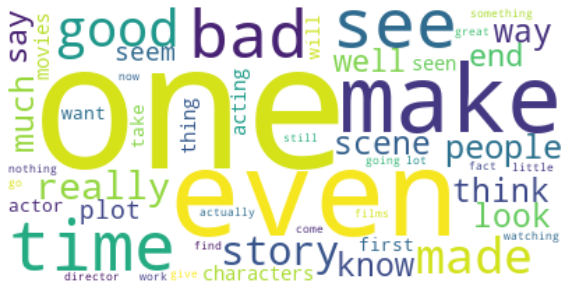

In [13]:
# join all the words in every negative review into one long text
text = " ".join(review for idx, review in enumerate(movies.clean) if movies['sentiment'][idx] == 'negative')

# drop stopwords - words that are common and irrelevant for themes e.g. the and in
stopwords = set(STOPWORDS)
# add movie specific stopwords that might not be that relevant for visualization
stopwords.update(['film', 'movie', 'show', 'character', 'direct', 'watch', 'act'])

# visualize with word cloud
wordcloud = WordCloud(stopwords=stopwords, max_words=50, background_color="white").generate(text)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

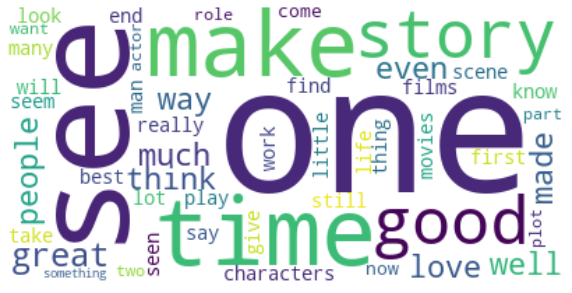

In [14]:
# join all the words in every positive review into one long text
text = " ".join(review for idx, review in enumerate(movies.clean) if movies['sentiment'][idx] == 'positive')

# drop stopwords - words that are common and irrelevant for themes e.g. the and in
stopwords = set(STOPWORDS)
# add movie specific stopwords that might not be that relevant for visualization
stopwords.update(['film', 'movie', 'show', 'character', 'direct', 'watch', 'act'])

# visualize with word cloud
wordcloud = WordCloud(stopwords=stopwords, max_words=50, background_color="white").generate(text)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As we can see above, most of the words are the same in both positive and negative reviews, but there is some difference with characterisictically good words (e.g. 'great', 'love', 'good') and bad words ('bad'). Interestingly, there is some crossover (e.g. good is a common word in the negative reviews, so perhaps this had a negative adverb preceeding it).

## Model
To build a model, the sentiment needs to first be encoded into a binary variable for the model to understand. After that, we can perform the train-test split and tokenize the words.

In [15]:
# encode the sentiments
# Where positive: 0 and negative: 1
movies['sen_enc'] = movies.sentiment.replace(to_replace=['positive', 'negative'], value=[0, 1])

In [16]:
# Split into train and test sets with a random state to ensure reproducibility
X_train, X_test, y_train, y_test = train_test_split(movies['clean'], movies['sen_enc'], test_size=0.20, random_state=12)

print('X_train:', X_train.shape)
print('Y_train:', y_train.shape)
print()
print('X_test:', X_test.shape)
print('Y_test:', y_test.shape)

X_train: (40000,)
Y_train: (40000,)

X_test: (10000,)
Y_test: (10000,)


As the data is now split into train and test, we can finish cleaning the datasets and apply the lemmatization and stemming methods.

In [17]:
# create list of stopwords from NLTK 
en_stopwords = list(set(nltk.corpus.stopwords.words('english')))

# remove punctuation from data
clean = [re.sub(r'[^\w\s]','',i).lower() for i in X_train]

# tokenize the words
tokens = [word_tokenize(x) for x in clean]
filtered_tokens = []

# Filter for the tokens that aren't stopwords
for review in tokens:
    filtered_tokens.append([])
    for word in review:
        if word in en_stopwords:
            continue
        else: 
            filtered_tokens[-1].append(word)

As mentioned previously, I try a variety stemming/lemmatization options to assess the impact of each on the classification accuracy. These were chosen for the following reasons: 
- Snowball Stemmer: An improved version of the classic Porter Stemmer from the 80s.
- Lancaster Stemmer: The most aggressive stemming algorithm. I included it out of curiousity to see how it would impact because if you look at an example lancaster stemmed review, some of the stems are extremely truncated.
- WordNet Lemmatizer: WordNet is NLTK's lemmatizer. Since NLTK is a classic NLP toolkit, it's relevant to compare since this is probably a classically used option. 
- SpaCy Lemmatizer: spaCy is an alternative to NLTK, so it'll be interesting to see how the accuracy achieved with the two lemmatizers will compare. 

In [20]:
# Find the Stem/Lemma
'''    
# Try with the Snowball Stemmer - better than the very basic porter stemmer
SB = SnowballStemmer(language='english')
SB_lemmatized = []
for review in filtered_tokens: 
    SB_lemmatized.append([SB.stem(word) for word in review])
'''

# Try with the Lancaster Stemmer - more aggressive approach to stemming
LS = LancasterStemmer()
LS_lemmatized = []
for review in filtered_tokens: 
    LS_lemmatized.append([LS.stem(word) for word in review])
  
# Try with Word Net Lemmatizer - NLTK's lemmatizer
WN = WordNetLemmatizer()
WN_lemmatized = []
for review in filtered_tokens: 
    WN_lemmatized.append([WN.lemmatize(word) for word in review])

'''   
# Try with SpaCy lemmatizer - spaCy's lemmatizer
# could do this if i want it to go faster nlp.disable_pipe("parser")/nlp.enable_pipe("senter")
SP_lemmatized = []
for review in clean: 
    SP_lemmatized.append([word.lemma_ for word in sp(review)])
'''  

'   \n# Try with SpaCy lemmatizer - spaCy\'s lemmatizer\n# could do this if i want it to go faster nlp.disable_pipe("parser")/nlp.enable_pipe("senter")\nSP_lemmatized = []\nfor review in clean: \n    SP_lemmatized.append([word.lemma_ for word in sp(review)])\n'

In [19]:
# Need to add this in for spacy, because it didn't use the stopwords cleaned version
# Filter for the tokens that aren't stopwords
en_stopwords = en_stopwords + [' ']

for idx, review in enumerate(SP_lemmatized):
    SP_lemmatized[idx] = [word for word in review if word not in en_stopwords]

In [21]:
# Define function to turn array into a string
# the lemmatized versions of the reviews are saved in an array, and putting that array into a row of the 
# dataframe complicates accessing it
def arr_cnv(col, data, df):
    lemma_text = []

    for idx, row in enumerate(data): 
        text = " ".join(word for word in row)
        lemma_text.append(text)
    
    return lemma_text

In [23]:
print(WN_lemmatized[0])

['disagree', 'people', 'saying', 'lousy', 'horror', 'film', 'good', 'acting', 'camerawork', 'id', 'say', 'okay', 'horror', 'flick', 'ruined', 'shockingly', 'abysmal', 'acting', 'poor', 'camerawork', 'watch', 'juon', 'grudge', 'instead', 'wasting', 'time', 'garbage', 'principal', 'idea', 'behind', 'film', 'rather', 'original', 'one', 'considering', 'abundance', 'killerdollbased', 'scarefests', 'foist', 'upon', 'u', 'year', 'unfortunately', 'story', 'handled', 'subtlety', 'latest', 'michael', 'bay', 'actioner', 'cast', 'character', 'uniformly', 'unlikable', 'played', 'precisionperfect', 'dreadfulness', 'actor', 'presumably', 'sifted', 'daytime', 'korean', 'soap', 'opera', 'isnt', 'scary', 'succeeds', 'dampening', 'expectation', 'next', 'korean', 'horror', 'movie', 'comeacalling', 'oh', 'well']


In [21]:
lemmas = pd.DataFrame({'snowball': SB_lemmatized, 'lancaster': LS_lemmatized, 'wordnet': WN_lemmatized, 'spacy': SP_lemmatized})

# convert the arrays of lemmatized/stemmed words into a string in the df
lemma_lst = 'snowball', 'lancaster', 'wordnet', 'spacy'

for col in lemma_lst:
    lemmas[col] = arr_cnv(col, lemmas[col], lemmas)
    

lemmas

,snowball,lancaster,wordnet,spacy
0,disagre peopl say lousi horror film good act c...,disagr peopl say lousy hor film good act camer...,disagree people saying lousy horror film good ...,disagree people say lousy horror film good act...
1,husbandandwif doctor team carol nile nelson mo...,husbandandw doct team carol nil nelson modest ...,husbandandwife doctor team carole nile nelson ...,husbandandwife doctor team carole nile nelson ...
2,like cast pretti much howev stori sort unfold ...,lik cast pretty much howev story sort unfold r...,like cast pretty much however story sort unfol...,I like cast pretty much however story sort unf...
3,movi aw bad cant bear expend anyth word avoid ...,movy aw bad cant bear expend anyth word avoid ...,movie awful bad cant bear expend anything word...,movie awful bad I ca nt bear expend anything w...
4,purchas blood castl dvd ebay buck know say was...,purchas blood castl dvd ebay buck know say was...,purchased blood castle dvd ebay buck knowing s...,I purchase blood castle dvd ebay buck know I s...
...,...,...,...,...
39995,strang thing see film scene work rather weak c...,strange thing see film scen work rath weak com...,strange thing see film scene work rather weakl...,strange thing see film scene work rather weakl...
39996,saw cheap dvd releas titl entiti forc sinc enj...,saw cheap dvd releas titl ent forc sint enjoy ...,saw cheap dvd release title entity force since...,I see cheap dvd release title entity force sin...
39997,one peculiar oftus romanc movi plot one seriou...,on peculi oftus rom movy plot on sery messedup...,one peculiar oftused romance movie plot one se...,one peculiar oftused romance movie plot one se...
39998,noth posit say meander nonsens huf puf messag ...,noth posit say meand nonsens huff puff mess ne...,nothing positive say meandering nonsense huffi...,nothing positive say meander nonsense huffing ...


In [22]:
# print the first review of each
for col in lemma_lst:
    print('The {} lemmatized version of the first review'.format(col))
    print(lemmas[col][0])
    print()

The snowball lemmatized version of the first review
disagre peopl say lousi horror film good act camerawork id say okay horror flick ruin shock abysm act poor camerawork watch juon grudg instead wast time garbag princip idea behind film rather origin one consid abund killerdollbas scarefest foist upon us year unfortun stori handl subtleti latest michael bay action cast charact uniform unlik play precisionperfect dread actor presum sift daytim korean soap opera isnt scari succeed dampen expect next korean horror movi comeacal oh well

The lancaster lemmatized version of the first review
disagr peopl say lousy hor film good act camerawork id say okay hor flick ruin shock abysm act poor camerawork watch juon grudg instead wast tim garb princip ide behind film rath origin on consid abund killerdollbas scarefest foist upon us year unfortun story handl subtl latest michael bay act cast charact uniform unlik play precisionperfect dread act presum sift daytim kor soap opera isnt scary success 

Looking at the lemmatized versions of the same review, it's possible to see the slight differences between each of the methods. Even just the first word (disagree) varies between each of the stemmed versions, while between the lemmatizers, WordNet keeps 'wasting' while spaCy has 'waste'. 

### For test set

In [23]:
# remove punctuation from data
test_clean = [re.sub(r'[^\w\s]','',i).lower() for i in X_test]

# tokenize the words
test_tokens = [word_tokenize(x) for x in test_clean]
test_filtered_tokens = []

# Filter for the tokens that aren't stopwords
for review in test_tokens:
    test_filtered_tokens.append([])
    for word in review:
        if word in en_stopwords:
            continue
        else: 
            test_filtered_tokens[-1].append(word)
            
# Find the Stemmer/Lemma
    
# Try with the Snowball Stemmer - apparently better than porter stemmer
testSB_lemmatized = []
for review in test_filtered_tokens: 
    testSB_lemmatized.append([SB.stem(word) for word in review])
    
# Try with the Snowball Stemmer - apparently better than porter stemmer
testLS_lemmatized = []
for review in test_filtered_tokens: 
    testLS_lemmatized.append([LS.stem(word) for word in review])
    
# Try with Word Net Lemmatizer
test_WN_lemmatized = []
for review in test_filtered_tokens: 
    test_WN_lemmatized.append([WN.lemmatize(word) for word in review])
    
# Try with SpaCy lemmatizer
# could do this if i want it to go faster nlp.disable_pipe("parser")/nlp.enable_pipe("senter")
testSP_lemmatized = []
for review in test_clean: 
    testSP_lemmatized.append([word.lemma_ for word in sp(review)])

In [24]:
# Need to add this in for spacy, because it didn't use the stopwords cleaned version
# Filter for the tokens that aren't stopwords
for idx, review in enumerate(testSP_lemmatized):
    testSP_lemmatized[idx] = [word for word in review if word not in en_stopwords]
    
test_lemmas = pd.DataFrame({'snowball': testSB_lemmatized, 'lancaster': testLS_lemmatized, 
                            'wordnet': test_WN_lemmatized, 'spacy': testSP_lemmatized})

for col in lemma_lst:
    test_lemmas[col] = arr_cnv(col, test_lemmas[col], test_lemmas)
    

test_lemmas

,snowball,lancaster,wordnet,spacy
0,hard tell noonan marshal tri ape abbott costel...,hard tel noon marshal try ap abbot costello ma...,hard tell noonan marshall trying ape abbott co...,hard tell noonan marshall try ape abbott coste...
1,well starta one review said know your real tre...,wel starta on review said know yo real tre see...,well startas one reviewer said know youre real...,well I startas one reviewer say know real trea...
2,wife kid opinion absolut abc classic havent se...,wif kid opin absolv abc class hav seen every e...,wife kid opinion absolute abc classic havent s...,wife kid opinion absolute abc classic I nt see...
3,surpris basic copycat comedi classic nutti pro...,surpr bas copyc comedy class nutty profess nau...,surprise basic copycat comedy classic nutty pr...,surprise basic copycat comedy classic nutty pr...
4,josef von sternberg direct magnific silent fil...,josef von sternberg direct magn sil film sil h...,josef von sternberg directs magnificent silent...,josef von sternberg direct magnificent silent ...
...,...,...,...,...
9995,yes fast time wannab still decent entertainmen...,ye fast tim wannab stil dec entertainmentsom c...,yes fast time wannabe still decent entertainme...,yes fast time wannabe still decent entertainme...
9996,run dont walk rent movi rereleas excel dvd ver...,run dont walk rent movy rereleas excel dvd ver...,run dont walk rent movie rereleased excellent ...,run nt walk rent movie rerelease excellent dvd...
9997,docudrama would expect richard attenborough ma...,docudram would expect richard attenborough man...,docudrama would expect richard attenborough ma...,docudrama would expect richard attenborough ma...
9998,nepot capitol world come anoth junk flick fanc...,nepot capitol world com anoth junk flick fant ...,nepotism capitol world come another junk flick...,nepotism capitol world come another junk flick...


In order to build the model, the movie reviews have to be tokenized, using Keras' Tokenizer module to build a word-to-index dictionary, where each word is a key, and the key's value is a unique index. Additionally, padding is used to ensure each of the reviews are the same length. 




In [25]:
## FOR SNOWBALL
maxlen = 250 

tokenizerSB = Tokenizer(num_words=5000)
tokenizerSB.fit_on_texts(lemmas['snowball'])

def prep_txt(reviews, tokenizer, max_seq_len):
    # Turn the text into a padded sequence
    text_seq = tokenizer.texts_to_sequences(reviews)
    return pad_sequences(text_seq, maxlen=max_seq_len)

X_trainSB = prep_txt(lemmas['snowball'], tokenizerSB, maxlen)
X_testSB = prep_txt(test_lemmas['snowball'], tokenizerSB, maxlen)


In [26]:
## FOR LANCASTER
tokenizerLS = Tokenizer(num_words=5000)
tokenizerLS.fit_on_texts(lemmas['lancaster'])

def prep_txt(reviews, tokenizer, max_seq_len):
    # Turn the text into a padded sequence
    text_seq = tokenizer.texts_to_sequences(reviews)
    return pad_sequences(text_seq, maxlen=max_seq_len)

X_trainLS = prep_txt(lemmas['lancaster'], tokenizerLS, maxlen)
X_testLS = prep_txt(test_lemmas['lancaster'], tokenizerLS, maxlen)

In [27]:
## FOR WORD NET

tokenizerWN = Tokenizer(num_words=5000)
tokenizerWN.fit_on_texts(lemmas['wordnet'])

def prep_txt(reviews, tokenizer, max_seq_len):
    # Turn the text into a padded sequence
    text_seq = tokenizer.texts_to_sequences(reviews)
    return pad_sequences(text_seq, maxlen=max_seq_len)

X_trainWN = prep_txt(lemmas['wordnet'], tokenizerWN, maxlen)
X_testWN = prep_txt(test_lemmas['wordnet'], tokenizerWN, maxlen)


In [28]:
## FOR SPACY

tokenizerSP = Tokenizer(num_words=5000)
tokenizerSP.fit_on_texts(lemmas['spacy'])

def prep_txt(reviews, tokenizer, max_seq_len):
    # Turn the text into a padded sequence
    text_seq = tokenizer.texts_to_sequences(reviews)
    return pad_sequences(text_seq, maxlen=max_seq_len)

X_trainSP = prep_txt(lemmas['spacy'], tokenizerSP, maxlen)
X_testSP = prep_txt(test_lemmas['spacy'], tokenizerSP, maxlen)


In [29]:
# Adding 1 because of reserved 0 index
vocab_sizeSB = len(tokenizerSB.word_index) + 1
print('Snowball:', vocab_sizeSB)

# Adding 1 because of reserved 0 index
vocab_sizeLS = len(tokenizerLS.word_index) + 1
print('Lancaster:', vocab_sizeLS)

# Adding 1 because of reserved 0 index
vocab_sizeWN = len(tokenizerWN.word_index) + 1
print('Word Net:', vocab_sizeWN)

# Adding 1 because of reserved 0 index
vocab_sizeSP = len(tokenizerSP.word_index) + 1
print('Spacy:', vocab_sizeSP)

Snowball: 155495
Lancaster: 138773
Word Net: 181648
Spacy: 172232


Here, I use GloVe for to create a feature matrix that represents the words in the review and their position relative to other words that are near it. I'll use this feature matrix for my weights in the embedding layer of the models. Importantly, this weight matrix is only for the weights that were seen in the training data sets. 

In [30]:
## Create feature matrix

embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [31]:
# FOR SNOWBALL
embSB = zeros((vocab_sizeSB, 100))
for word, index in tokenizerSB.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embSB[index] = embedding_vector

# FOR LANCASTER     
embLS = zeros((vocab_sizeLS, 100))
for word, index in tokenizerLS.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embLS[index] = embedding_vector
        
# FOR WORD NET     
embWN = zeros((vocab_sizeWN, 100))
for word, index in tokenizerWN.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embWN[index] = embedding_vector

# FOR SPACY
embSP = zeros((vocab_sizeSP, 100))
for word, index in tokenizerSP.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embSP[index] = embedding_vector

#### Store all of our results to a DF

By storing all of the results in a dataframe, we can access each lemmatizer/stemmer option and train the models on each one in an iterative way.

In [32]:
vocab_list = (vocab_sizeSB, vocab_sizeLS, vocab_sizeWN, vocab_sizeSP)
embmat_list = (embSB, embLS, embWN, embSP)
Xtrain_list = (X_trainSB, X_trainLS, X_trainWN, X_trainSP)
Xtest_list = (X_testSB, X_testLS, X_testWN, X_testSP)

full_df = pd.DataFrame({
    'Vocab': vocab_list,
    'Embmat': embmat_list,
    'Xtrain': Xtrain_list,
    'Xtest': Xtest_list
}, index = ['SB', 'LS', 'WN', 'SP'])
full_df

,Vocab,Embmat,Xtrain,Xtest
SB,155495,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
LS,138773,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
WN,181648,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
SP,172232,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# Models
The following portions of the model implementation are the same across each of the neural networks, so the choices are rationalized here: 
- Model: I use the sequential model as I only have one input, the movie review, and one output, the binary classification of sentiment. 
- Embedding Layer: The first layer is the embedding layer which turns integers into vectors. It has a vocabulary size of whichever lemmatizer option is being used. For the weights, I use the word embedding matrix that was built previously, which also constrains the output dimensions, as I used the 100-dimensional version of GloVe. 
- Dropout Layers: I added dropout layers to the models in an attempt to prevent overfitting, which randomly selects 20% of the neurons to be ignored.
- Final Layer: For all of the neural networks, I use a final Dense layer with sigmoid activation for the output layer, as the final goal is to predict a probability as an output, and the sigmoid function transforms the input into a range between 0 and 1. 
- Optimizer: I initially tested both the SGD and Adam optimizer after a literature review noted Adam was faster, but sometimes has errors which SGD doesn't, but there wasn't that much variation in the accuracy scores, so I ultimately used the Adam optimizer.
- Loss Function: I use binary cross entropy for the loss function, as we're attempting a binary classification.
- Fit: I fit the model with a validation split, setting aside 20% of the training data to use as a validation set, so after every epoch, the loss and accuracy is evaluated on this portion of the data.
- Epochs: I train with few epochs to prevent the model from memorizing the data and overfitting

### Simple Neural Network

The first model that I'll train is a simple neural network. There's not much to add here, it uses 1 of each of the previously explained layers. 

### Convolutional Neural Network
The second model I train is a convolutional neural network which even though traditionally applied to images, can also perform well with NLP tasks. I used a 1D CNN with an embedding layer constructed like the simple NN and a mix of convolutional layers with the non linear ReLu function as the activation function and pooling layers. The pooling layers help prevent overfitting through down-sampling, since the reduction of size in this layer leads to some information loss.

### Recurrent Neural Network 
Recurrent neural networks work well with sequential data, by reusing activations of previous nodes or later nodes in the sequence to influence the output, so it's well suited to be applied to detect sentiment in a sequence of words in a review. The Long Short Term Memory network has been classically applied to [text-related problems](https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f) and here, I apply it with a combination of the same embedding layer, droupout layers and dense output layer as described previously. 

In [86]:
def simpleNN(vocab, embed_matrix, X_train, y_train, X_test, y_test, cv = False):
    # build the model
    model = Sequential()
    embedding_layer = Embedding(vocab, 100, weights=[embed_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    if cv == True: 
        history = model.fit(X_train, y_train, batch_size=128, epochs=4, verbose=1)
    else:
        # fit the model
        history = model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)
    
        # evaluate model
    score = model.evaluate(X_test, y_test, verbose=1)
    
    return history, score

def CNN(vocab, embed_matrix, X_train, y_train, X_test, y_test, cv=False):
    model = Sequential()

    embedding_layer = Embedding(vocab, 100, weights=[embed_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(Dropout(0.2))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    if cv == True: 
        history = model.fit(X_train, y_train, batch_size=128, epochs=4, verbose=1)
    else:
        # fit the model
        history = model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)
    
    # evaluate model
    score = model.evaluate(X_test, y_test, verbose=1)
    
    return history, score

def RNN(vocab, embed_matrix, X_train, y_train, X_test, y_test, cv=False):
    model = Sequential()

    embedding_layer = Embedding(vocab, 100, weights=[embed_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    if cv == True: 
        history = model.fit(X_train, y_train, batch_size=128, epochs=4, verbose=1)
    else:
        # fit the model
        history = model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)
    
    # evaluate model
    score = model.evaluate(X_test, y_test, verbose=1)
    
    return history, score


def plotNN(history, score, lemmat):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    
    plt.title('Model Accuracy for {}'.format(lemmat))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'], loc = 'upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model Loss for {}'.format(lemmat))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'], loc = 'upper left')
    plt.show()
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])
    
    return score[0], score[1]

lemma_options = ['SB', 'LS', 'WN', 'SP']
n_folds = 3
model_list = ['simpleNN', 'CNN', 'RNN']

### Cross Validation

Cross validation is crucial to evaluate a model's performance, in this section I use Sklearn's K-fold cross validation, which selects different subsets of the training data as a train and validation set to evaluate the model during each fold. The average classification accuracy scores for each model/lemmatizer were as follows:

| Simple NN: Lemmatizer | Classification Accuracy| Standard Deviation |
| -------------| -----------| -----------| 
| Snowball | 72.7 | 0.32
| Lancaster | 70.1 | 0.12
| WordNet | 75.4 | 0.45
| Spacy | 76.2 | 0.61

| CNN: Lemmatizer | Classification Accuracy|Standard Deviation |
| -------------| -----------| -----------| 
| Snowball | 81.6 | .37
| Lancaster | 80.3 | .55
| WordNet | 83.9 | .65
| Spacy | 83.3 | 0.86


| RNN: Lemmatizer | Classification Accuracy|Standard Deviation |
| -------------| -----------| -----------| 
| Snowball | 82.4 | .83
| Lancaster | 80.5 | .21
| WordNet | 84.9 | .93
| Spacy | 84.4 | .54



In [82]:
# K Fold CV
# inspired from https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

for model in model_list:
    print('------------------------------------------------------------------------')
    print('Cross Validation for {}'.format(model))
    print('------------------------------------------------------------------------')
    for l in lemma_options: 
        acc_per_fold = []
        loss_per_fold = []

        inputs = np.array(full_df.loc[l, 'Xtrain'])
        targets = np.array(y_train)

        # Define the K-fold Cross Validator
        kfold = KFold(n_splits=n_folds, shuffle=True)

        # K-fold Cross Validation model evaluation
        fold_no = 1
    
        print('------------------------------------------------------------------------')
        print('Training for Lemmatizer {}'.format(l))
        print('------------------------------------------------------------------------')
    
        # test it on the model
        for train, test in kfold.split(inputs, targets):
            print('------------------------------------------------------------------------')
            print('Training for fold {} ...'.format(fold_no))
            if model == 'simpleNN':
                history, score = simpleNN(full_df.loc[l, 'Vocab'], full_df.loc[l, 'Embmat'], inputs[train], 
                             targets[train], inputs[test], targets[test], True)
            elif model == 'CNN':
                history, score = CNN(full_df.loc[l, 'Vocab'], full_df.loc[l, 'Embmat'], inputs[train], 
                             targets[train], inputs[test], targets[test], True)
            else: 
                history, score = RNN(full_df.loc[l, 'Vocab'], full_df.loc[l, 'Embmat'], inputs[train], 
                             targets[train], inputs[test], targets[test], True)
            acc_per_fold.append(score[1] * 100)
            loss_per_fold.append(score[0])
            print('Score for fold {:.2f}: Accuracy {:.2f}; Loss {:.2f}'.format(fold_no, score[1], score[0]))
            # Increase fold number
            fold_no = fold_no + 1
        
        print('------------------------------------------------------------------------')
        print('{}: Score per fold for Lemmatizer {}'.format(model, l))
        for i in range(0, len(acc_per_fold)):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds for Lemmatizer {}:'.format(l))
        print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Cross Validation for simpleNN
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for Lemmatizer SB
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/4
209/209 [==============================] - 5s 21ms/step - loss: 0.6619 - acc: 0.6073
Epoch 2/4
209/209 [==============================] - 5s 24ms/step - loss: 0.4933 - acc: 0.7608
Epoch 3/4
209/209 [==============================] - 5s 24ms/step - loss: 0.4544 - acc: 0.7861
Epoch 4/4
417/417 [==============================] - 1s 1ms/step - loss: 0.5605 - acc: 0.7314
Score for fold 1.00: Accuracy 0.73; Loss 0.56
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/4
209/209 [=============

## Evaluation on the Test Data

Epoch 1/8
250/250 [==============================] - 8s 26ms/step - loss: 0.6488 - acc: 0.6250 - val_loss: 0.5798 - val_acc: 0.7055
Epoch 2/8
250/250 [==============================] - 6s 22ms/step - loss: 0.4964 - acc: 0.7589 - val_loss: 0.5610 - val_acc: 0.7266
Epoch 3/8
250/250 [==============================] - 5s 20ms/step - loss: 0.4664 - acc: 0.7744 - val_loss: 0.5646 - val_acc: 0.7260
Epoch 4/8
250/250 [==============================] - 5s 21ms/step - loss: 0.4471 - acc: 0.7832 - val_loss: 0.5707 - val_acc: 0.7228
Epoch 5/8
250/250 [==============================] - 5s 22ms/step - loss: 0.4392 - acc: 0.7933 - val_loss: 0.5842 - val_acc: 0.7219
Epoch 6/8
250/250 [==============================] - 6s 23ms/step - loss: 0.4317 - acc: 0.7920 - val_loss: 0.6069 - val_acc: 0.7138
Epoch 7/8
250/250 [==============================] - 6s 24ms/step - loss: 0.4179 - acc: 0.8029 - val_loss: 0.6040 - val_acc: 0.7206
Epoch 8/8
313/313 [==============================] - 1s 2ms/step - loss: 0.5

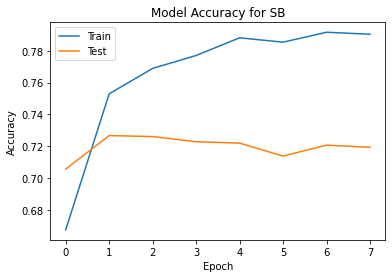

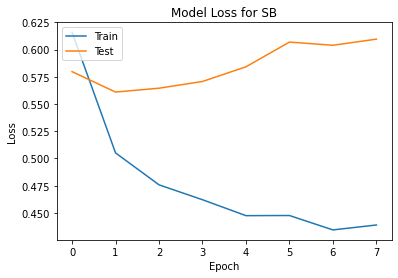

Test Score: 0.5995514392852783
Test Accuracy: 0.7232999801635742
Epoch 1/8
250/250 [==============================] - 7s 25ms/step - loss: 0.6715 - acc: 0.5949 - val_loss: 0.5848 - val_acc: 0.6939
Epoch 2/8
250/250 [==============================] - 6s 23ms/step - loss: 0.5156 - acc: 0.7438 - val_loss: 0.5830 - val_acc: 0.7011
Epoch 3/8
250/250 [==============================] - 6s 25ms/step - loss: 0.4800 - acc: 0.7666 - val_loss: 0.6048 - val_acc: 0.6977
Epoch 4/8
250/250 [==============================] - 5s 22ms/step - loss: 0.4586 - acc: 0.7793 - val_loss: 0.5995 - val_acc: 0.7067
Epoch 5/8
250/250 [==============================] - 6s 23ms/step - loss: 0.4539 - acc: 0.7820 - val_loss: 0.6127 - val_acc: 0.7015
Epoch 6/8
250/250 [==============================] - 5s 21ms/step - loss: 0.4510 - acc: 0.7808 - val_loss: 0.6185 - val_acc: 0.7078
Epoch 7/8
250/250 [==============================] - 6s 22ms/step - loss: 0.4459 - acc: 0.7841 - val_loss: 0.6325 - val_acc: 0.7040
Epoch 8/8
3

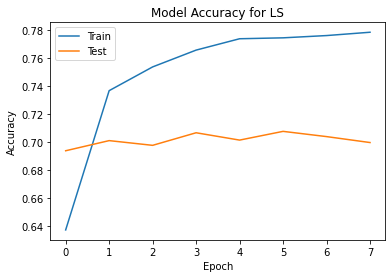

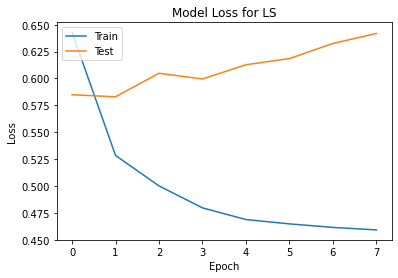

Test Score: 0.6663588285446167
Test Accuracy: 0.6901999711990356
Epoch 1/8
250/250 [==============================] - 7s 24ms/step - loss: 0.6318 - acc: 0.6423 - val_loss: 0.5119 - val_acc: 0.7509
Epoch 2/8
250/250 [==============================] - 6s 22ms/step - loss: 0.4701 - acc: 0.7764 - val_loss: 0.5226 - val_acc: 0.7459
Epoch 3/8
250/250 [==============================] - 6s 22ms/step - loss: 0.4277 - acc: 0.8004 - val_loss: 0.5061 - val_acc: 0.7574
Epoch 4/8
250/250 [==============================] - 5s 21ms/step - loss: 0.4157 - acc: 0.8076 - val_loss: 0.5223 - val_acc: 0.7496
Epoch 5/8
250/250 [==============================] - 5s 20ms/step - loss: 0.4054 - acc: 0.8121 - val_loss: 0.5280 - val_acc: 0.7529
Epoch 6/8
250/250 [==============================] - 5s 20ms/step - loss: 0.3959 - acc: 0.8167 - val_loss: 0.5342 - val_acc: 0.7542
Epoch 7/8
250/250 [==============================] - 5s 20ms/step - loss: 0.3957 - acc: 0.8192 - val_loss: 0.5417 - val_acc: 0.7538
Epoch 8/8
3

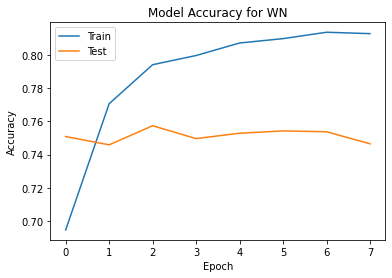

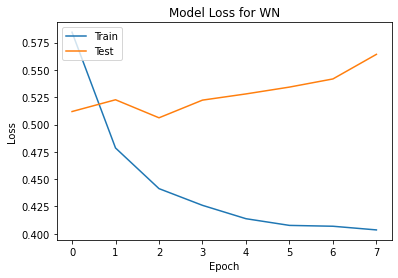

Test Score: 0.5700196027755737
Test Accuracy: 0.7530999779701233
Epoch 1/8
250/250 [==============================] - 6s 21ms/step - loss: 0.6226 - acc: 0.6589 - val_loss: 0.5073 - val_acc: 0.7585
Epoch 2/8
250/250 [==============================] - 5s 20ms/step - loss: 0.4648 - acc: 0.7819 - val_loss: 0.4972 - val_acc: 0.7679
Epoch 3/8
250/250 [==============================] - 5s 20ms/step - loss: 0.4238 - acc: 0.8040 - val_loss: 0.5161 - val_acc: 0.7574
Epoch 4/8
250/250 [==============================] - 5s 20ms/step - loss: 0.4122 - acc: 0.8078 - val_loss: 0.5135 - val_acc: 0.7611
Epoch 5/8
250/250 [==============================] - 5s 20ms/step - loss: 0.4058 - acc: 0.8107 - val_loss: 0.5234 - val_acc: 0.7611
Epoch 6/8
250/250 [==============================] - 5s 20ms/step - loss: 0.3962 - acc: 0.8158 - val_loss: 0.5585 - val_acc: 0.7483
Epoch 7/8
250/250 [==============================] - 5s 20ms/step - loss: 0.3844 - acc: 0.8245 - val_loss: 0.5344 - val_acc: 0.7607
Epoch 8/8
3

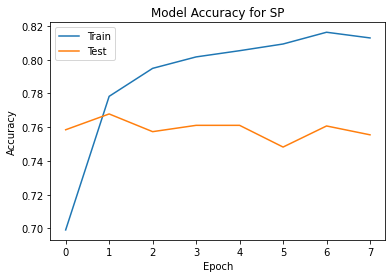

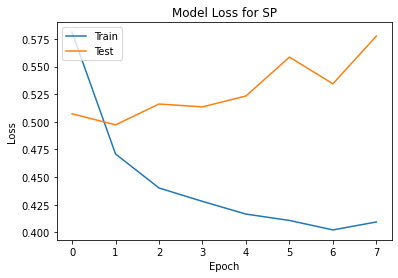

Test Score: 0.5807396769523621
Test Accuracy: 0.7509999871253967
[['SB', 0.5995514392852783, 0.7232999801635742, <tensorflow.python.keras.callbacks.History object at 0x7fe38da12ca0>], ['LS', 0.6663588285446167, 0.6901999711990356, <tensorflow.python.keras.callbacks.History object at 0x7fe3379cd280>], ['WN', 0.5700196027755737, 0.7530999779701233, <tensorflow.python.keras.callbacks.History object at 0x7fe3ab149490>], ['SP', 0.5807396769523621, 0.7509999871253967, <tensorflow.python.keras.callbacks.History object at 0x7fe3a7ff22e0>]]


In [87]:
simpleNN_results = []

for l in lemma_options: 
    # model and plot each lemma option
    history, score = simpleNN(full_df.loc[l, 'Vocab'], full_df.loc[l, 'Embmat'], full_df.loc[l, 'Xtrain'], 
                             y_train, full_df.loc[l, 'Xtest'], y_test)
    plotNN(history, score, l)
    simpleNN_results.append([l, score[0], score[1], history])
    
print(simpleNN_results)

### Simple NN Results
| Simple NN: Lemmatizer | Classification Accuracy| 
| -------------| -----------| 
| Snowball | 72 
| Lancaster | 69
| WordNet | 75 
| Spacy | 75

As shown above, the lemmatizers outperform the stemmers on the simple neural network, though snowball comes close to the classification accuracy of the lemmatizers. The Lancaster stemmer performs the worst of the group, as was previously expected due to its aggressive stemming tactics which led to the lowest vocabulary size (138,773) implying that different words were stemmed to the same root, though they could have different meanings. Overall however, this is a pretty good classification accuracy (mean of 73 across all stemming/lemmatizing methods), however adding more and different layers as is done in the following models may improve the accuracy. This model had some overfitting, with a 5-8 point drop in accuracy depending on the lemmatizer used. However, this isn't a huge amount of overfitting in part I believe because of the addition of the dropout layers and curtailed epochs. 

Epoch 1/8
250/250 [==============================] - 30s 117ms/step - loss: 0.7261 - acc: 0.5636 - val_loss: 0.5364 - val_acc: 0.7651
Epoch 2/8
250/250 [==============================] - 29s 116ms/step - loss: 0.5119 - acc: 0.7517 - val_loss: 0.4880 - val_acc: 0.7916
Epoch 3/8
250/250 [==============================] - 32s 127ms/step - loss: 0.4655 - acc: 0.7824 - val_loss: 0.4720 - val_acc: 0.7786
Epoch 4/8
250/250 [==============================] - 38s 152ms/step - loss: 0.4283 - acc: 0.8004 - val_loss: 0.4406 - val_acc: 0.8135
Epoch 5/8
250/250 [==============================] - 31s 123ms/step - loss: 0.4199 - acc: 0.8100 - val_loss: 0.4304 - val_acc: 0.8224
Epoch 6/8
250/250 [==============================] - 31s 123ms/step - loss: 0.3918 - acc: 0.8250 - val_loss: 0.4111 - val_acc: 0.8251
Epoch 7/8
250/250 [==============================] - 32s 127ms/step - loss: 0.3815 - acc: 0.8306 - val_loss: 0.4126 - val_acc: 0.8199
Epoch 8/8
313/313 [==============================] - 3s 9ms/st

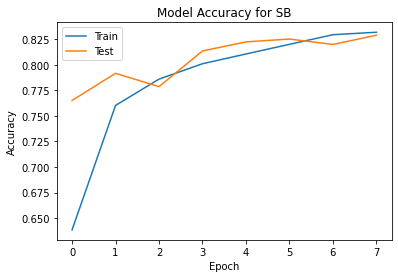

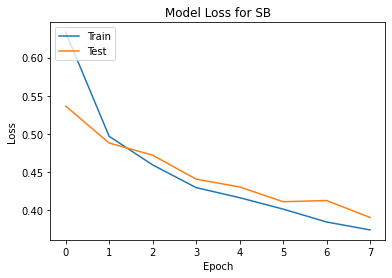

Test Score: 0.3927653133869171
Test Accuracy: 0.8291000127792358
Epoch 1/8
250/250 [==============================] - 32s 124ms/step - loss: 0.7526 - acc: 0.5461 - val_loss: 0.5831 - val_acc: 0.7366
Epoch 2/8
250/250 [==============================] - 31s 123ms/step - loss: 0.5436 - acc: 0.7251 - val_loss: 0.5054 - val_acc: 0.7821
Epoch 3/8
250/250 [==============================] - 32s 128ms/step - loss: 0.4775 - acc: 0.7736 - val_loss: 0.5054 - val_acc: 0.7797
Epoch 4/8
250/250 [==============================] - 30s 120ms/step - loss: 0.4549 - acc: 0.7842 - val_loss: 0.4548 - val_acc: 0.8095
Epoch 5/8
250/250 [==============================] - 31s 122ms/step - loss: 0.4258 - acc: 0.8059 - val_loss: 0.4616 - val_acc: 0.8067
Epoch 6/8
250/250 [==============================] - 31s 123ms/step - loss: 0.4091 - acc: 0.8143 - val_loss: 0.4237 - val_acc: 0.8140
Epoch 7/8
250/250 [==============================] - 33s 132ms/step - loss: 0.3930 - acc: 0.8226 - val_loss: 0.4226 - val_acc: 0.81

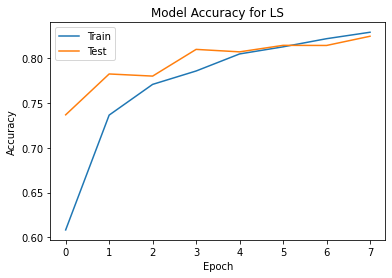

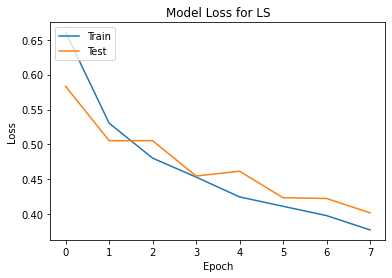

Test Score: 0.40619245171546936
Test Accuracy: 0.8241000175476074
Epoch 1/8
250/250 [==============================] - 30s 116ms/step - loss: 0.7300 - acc: 0.5865 - val_loss: 0.4841 - val_acc: 0.7961
Epoch 2/8
250/250 [==============================] - 31s 123ms/step - loss: 0.4635 - acc: 0.7833 - val_loss: 0.4220 - val_acc: 0.8235
Epoch 3/8
250/250 [==============================] - 30s 119ms/step - loss: 0.4082 - acc: 0.8153 - val_loss: 0.3961 - val_acc: 0.8413
Epoch 4/8
250/250 [==============================] - 30s 119ms/step - loss: 0.3881 - acc: 0.8273 - val_loss: 0.4099 - val_acc: 0.8444
Epoch 5/8
250/250 [==============================] - 30s 121ms/step - loss: 0.3727 - acc: 0.8352 - val_loss: 0.3746 - val_acc: 0.8510
Epoch 6/8
250/250 [==============================] - 29s 116ms/step - loss: 0.3575 - acc: 0.8426 - val_loss: 0.3896 - val_acc: 0.8295
Epoch 7/8
250/250 [==============================] - 30s 120ms/step - loss: 0.3523 - acc: 0.8462 - val_loss: 0.3616 - val_acc: 0.8

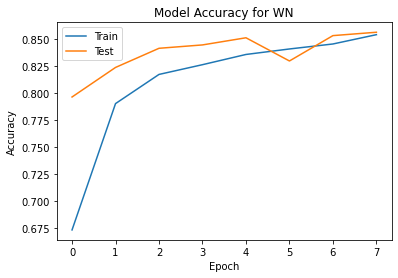

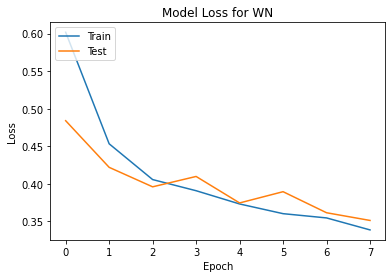

Test Score: 0.3500959873199463
Test Accuracy: 0.8557999730110168
Epoch 1/8
250/250 [==============================] - 31s 118ms/step - loss: 0.7169 - acc: 0.5892 - val_loss: 0.4882 - val_acc: 0.7983
Epoch 2/8
250/250 [==============================] - 29s 115ms/step - loss: 0.4568 - acc: 0.7855 - val_loss: 0.4299 - val_acc: 0.8139
Epoch 3/8
250/250 [==============================] - 28s 112ms/step - loss: 0.4173 - acc: 0.8105 - val_loss: 0.3995 - val_acc: 0.8403
Epoch 4/8
250/250 [==============================] - 28s 112ms/step - loss: 0.3899 - acc: 0.8303 - val_loss: 0.3833 - val_acc: 0.8456
Epoch 5/8
250/250 [==============================] - 28s 113ms/step - loss: 0.3737 - acc: 0.8356 - val_loss: 0.3886 - val_acc: 0.8460
Epoch 6/8
250/250 [==============================] - 29s 115ms/step - loss: 0.3641 - acc: 0.8407 - val_loss: 0.3712 - val_acc: 0.8454
Epoch 7/8
250/250 [==============================] - 29s 115ms/step - loss: 0.3509 - acc: 0.8500 - val_loss: 0.3721 - val_acc: 0.85

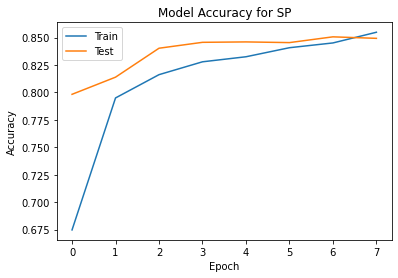

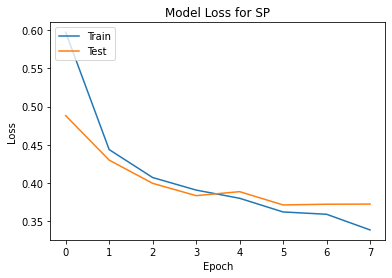

Test Score: 0.37205782532691956
Test Accuracy: 0.8500999808311462
[['SB', 0.3927653133869171, 0.8291000127792358], ['LS', 0.40619245171546936, 0.8241000175476074], ['WN', 0.3500959873199463, 0.8557999730110168], ['SP', 0.37205782532691956, 0.8500999808311462]]


In [88]:
CNN_results = []

for l in lemma_options: 
    # model and plot each lemma option
    history, score = CNN(full_df.loc[l, 'Vocab'], full_df.loc[l, 'Embmat'], full_df.loc[l, 'Xtrain'], 
                             y_train, full_df.loc[l, 'Xtest'], y_test)
    plotNN(history, score, l)
    CNN_results.append([l, score[0], score[1]])
    
print(CNN_results)

### CNN Results
| CNN: Lemmatizer | Classification Accuracy| 
| -------------| -----------| 
| Snowball | 82 
| Lancaster | 80
| WordNet | 85
| Spacy | 84

Similarly to the simple neural network, the lemmatizers outperform the stemmers, with the Snowball Stemmer coming close to the lemmatizer's classification accuracies and the Lancaster stemmer performing the worst. This model outperformed the previous model, achieving a mean accuracy of 83. The model was extremely good at not overfitting, achieving a 1-3 point difference between the training and testing accuracies of each lemmatizer. In fact, each of these point differences was due to the test set having a higher accuracy than the training set. The addition of the dropout layers and curtailed epochs (the model had a higher training accuracy over 4 epochs, but the test accuracy remained the same) helped avoid overfitting. 


Epoch 1/8
250/250 [==============================] - 106s 413ms/step - loss: 0.5915 - acc: 0.6774 - val_loss: 0.5090 - val_acc: 0.7556
Epoch 2/8
250/250 [==============================] - 105s 420ms/step - loss: 0.4961 - acc: 0.7651 - val_loss: 0.4378 - val_acc: 0.8049
Epoch 3/8
250/250 [==============================] - 103s 411ms/step - loss: 0.4430 - acc: 0.7928 - val_loss: 0.4181 - val_acc: 0.8148
Epoch 4/8
250/250 [==============================] - 105s 420ms/step - loss: 0.3962 - acc: 0.8218 - val_loss: 0.4215 - val_acc: 0.8094
Epoch 5/8
250/250 [==============================] - 107s 430ms/step - loss: 0.3803 - acc: 0.8327 - val_loss: 0.3677 - val_acc: 0.8443
Epoch 6/8
250/250 [==============================] - 105s 418ms/step - loss: 0.3628 - acc: 0.8389 - val_loss: 0.3758 - val_acc: 0.8472
Epoch 7/8
250/250 [==============================] - 105s 421ms/step - loss: 0.3362 - acc: 0.8556 - val_loss: 0.3547 - val_acc: 0.8512
Epoch 8/8
313/313 [==============================] - 15

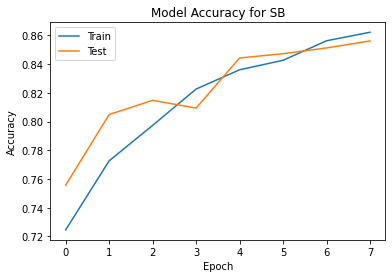

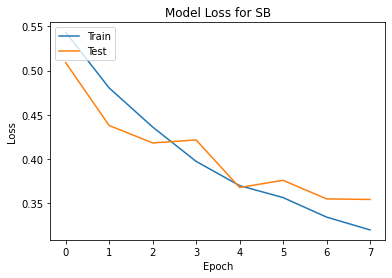

Test Score: 0.3541834056377411
Test Accuracy: 0.85589998960495
Epoch 1/8
250/250 [==============================] - 96s 375ms/step - loss: 0.5908 - acc: 0.6744 - val_loss: 0.5349 - val_acc: 0.7303
Epoch 2/8
250/250 [==============================] - 90s 361ms/step - loss: 0.5317 - acc: 0.7364 - val_loss: 0.4551 - val_acc: 0.7935
Epoch 3/8
250/250 [==============================] - 89s 358ms/step - loss: 0.4527 - acc: 0.7900 - val_loss: 0.4108 - val_acc: 0.8144
Epoch 4/8
250/250 [==============================] - 105s 420ms/step - loss: 0.4098 - acc: 0.8141 - val_loss: 0.4332 - val_acc: 0.7945
Epoch 5/8
250/250 [==============================] - 3322s 13s/step - loss: 0.3893 - acc: 0.8275 - val_loss: 0.4519 - val_acc: 0.7831
Epoch 6/8
250/250 [==============================] - 1347s 5s/step - loss: 0.3780 - acc: 0.8319 - val_loss: 0.3581 - val_acc: 0.8461
Epoch 7/8
250/250 [==============================] - 1263s 5s/step - loss: 0.3404 - acc: 0.8503 - val_loss: 0.3448 - val_acc: 0.8553


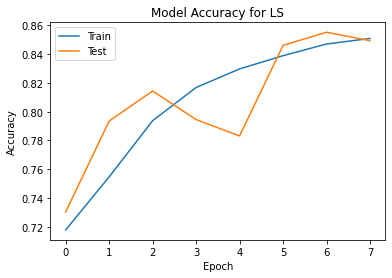

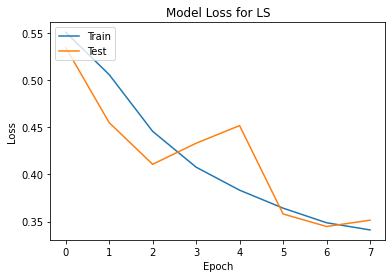

Test Score: 0.35141491889953613
Test Accuracy: 0.8497999906539917
Epoch 1/8
250/250 [==============================] - 95s 374ms/step - loss: 0.5721 - acc: 0.6900 - val_loss: 0.4368 - val_acc: 0.8035
Epoch 2/8
250/250 [==============================] - 2952s 12s/step - loss: 0.4305 - acc: 0.8031 - val_loss: 0.3694 - val_acc: 0.8453
Epoch 3/8
250/250 [==============================] - 2959s 12s/step - loss: 0.3743 - acc: 0.8335 - val_loss: 0.3385 - val_acc: 0.8555
Epoch 4/8
250/250 [==============================] - 6388s 26s/step - loss: 0.3467 - acc: 0.8520 - val_loss: 0.3265 - val_acc: 0.8633
Epoch 5/8
250/250 [==============================] - 91s 362ms/step - loss: 0.3315 - acc: 0.8604 - val_loss: 0.3193 - val_acc: 0.8659
Epoch 6/8
250/250 [==============================] - 88s 351ms/step - loss: 0.3139 - acc: 0.8685 - val_loss: 0.3327 - val_acc: 0.8662
Epoch 7/8
250/250 [==============================] - 99s 395ms/step - loss: 0.3033 - acc: 0.8725 - val_loss: 0.3002 - val_acc: 0.8

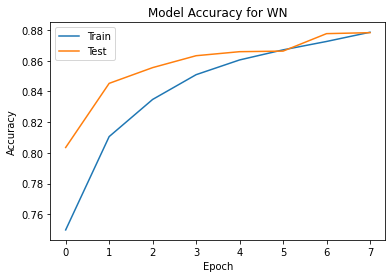

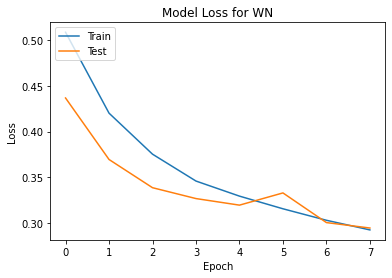

Test Score: 0.2938985228538513
Test Accuracy: 0.8741000294685364
Epoch 1/8
250/250 [==============================] - 95s 373ms/step - loss: 0.5542 - acc: 0.7086 - val_loss: 0.4170 - val_acc: 0.8110
Epoch 2/8
250/250 [==============================] - 90s 361ms/step - loss: 0.4261 - acc: 0.8089 - val_loss: 0.3901 - val_acc: 0.8263
Epoch 3/8
250/250 [==============================] - 97s 387ms/step - loss: 0.3942 - acc: 0.8238 - val_loss: 0.3538 - val_acc: 0.8493
Epoch 4/8
250/250 [==============================] - 97s 387ms/step - loss: 0.3633 - acc: 0.8434 - val_loss: 0.3318 - val_acc: 0.8614
Epoch 5/8
250/250 [==============================] - 96s 385ms/step - loss: 0.3360 - acc: 0.8567 - val_loss: 0.3376 - val_acc: 0.8612
Epoch 6/8
250/250 [==============================] - 91s 363ms/step - loss: 0.3249 - acc: 0.8599 - val_loss: 0.4031 - val_acc: 0.8394
Epoch 7/8
250/250 [==============================] - 96s 385ms/step - loss: 0.3112 - acc: 0.8698 - val_loss: 0.3139 - val_acc: 0.86

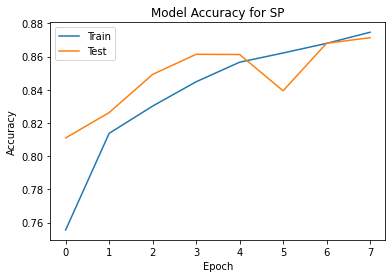

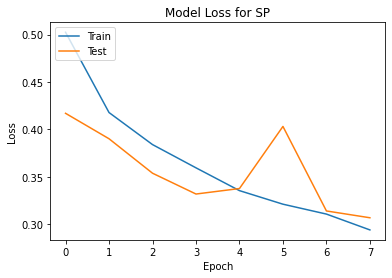

Test Score: 0.3014349639415741
Test Accuracy: 0.8727999925613403
[['SB', 0.3541834056377411, 0.85589998960495], ['LS', 0.35141491889953613, 0.8497999906539917], ['WN', 0.2938985228538513, 0.8741000294685364], ['SP', 0.3014349639415741, 0.8727999925613403]]


In [89]:
RNN_results = []

for l in lemma_options: 
    # model and plot each lemma option
    history, score = RNN(full_df.loc[l, 'Vocab'], full_df.loc[l, 'Embmat'], full_df.loc[l, 'Xtrain'], 
                             y_train, full_df.loc[l, 'Xtest'], y_test)
    plotNN(history, score, l)
    RNN_results.append([l, score[0], score[1]])
    
print(RNN_results)

### RNN Results
| RNN: Lemmatizer | Classification Accuracy| 
| -------------| -----------| 
| Snowball | 84
| Lancaster | 83
| WordNet | 85
| Spacy | 86

Similarly to the previous models, the lemmatizers outperform the stemmers, with the Snowball Stemmer coming close to the lemmatizer's classification accuracies and the Lancaster stemmer performing the worst. Despite RNNs being better equipped to deal with sequential data, this model barely outperformed the previous model, achieving a mean accuracy of 85. The model was also extremely good at not overfitting, achieving a 1-3 point difference between the training and testing accuracies of each lemmatizer, and performing better on the test set like the CNN. The addition of the dropout layers and curtailed epochs (the model had a higher training accuracy over 4 epochs, but the test accuracy remained the same) helped avoid overfitting. 

## Conclusions

__Comparison of the Lemmatizers:__

The lemmatizers outperformed the stemmers on all models. WordNet and SpaCy acheived roughly equal results, though WordNet outperformed SpaCy with the CNN, SpaCy outperformed WordNet on the RNN. However, these were only by 1 point, so there's not a signficant difference. There is however, a signficant difference with the computational time needed to lemmatize the words with each library, SpaCy takes at least 3x as long as WordNet. To reduce data processing time, WordNet would be the better choice over SpaCy, at least for this movie review case study and these models.

| Lemmatizer | Simple NN (Acc) | CNN (Acc) | RNN (Acc) | 
| -------------| -----------| -------------| -----------|
| Snowball | 72 |82 |84
| Lancaster | 69 | 80 |83
| WordNet | 75 |85 |85
| Spacy | 75 |84 | 86

    
     
__Model Comparison: Classification Accuracy__    
With regards to the models, the recurrent neural network outperformed the other models with the mean of the classification accuracy between all the lemmatizers. This is a logical result, as RNNs are suited for sequential data. However, it was computationally more expensive, each epoch taking 3x as long to train as the CNN. If computational complexity is a concern, the convolutional neural network is much faster to train and achieves only 2 points less on the mean accuracy so could be an appropriate choice. 

| Model | Mean Accuracy| 
| -------------| -----------| 
| Simple NN | 73
| CNN | 83
| RNN | 85


Ultimately, these accuracy scores were on par with what I had seen online ([here](https://medium.com/@MarynaL/analyzing-movie-review-data-with-natural-language-processing-7c5cba6ed922), [here](https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/), [here](https://www.kaggle.com/jekyllandhyde8999/sentiment-analysis-with-lstms-in-keras)). To improve the accuracy results, the model could be trained for longer, as in the case of RNN, I saw some models online that implemented similar versions of LSTM and achieved higher accuracy, but with greater numbers of epochs. 




## Citations: 
The main sources I looked at or used as reference/inspiration/etc for this assignment.

- [Brownlee, J. (2020, August 26). Dropout regularization in deep learning models with keras. Retrieved April 23, 2021, from https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

- [Brownlee, J. (2021, February 01). How to use word embedding layers for deep learning with keras. Retrieved April 23, 2021, from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

- [Heidenreich, H. (2018, December 21). Stemming? Lemmatization? WHAT? Retrieved April 23, 2021, from https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8](https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8)

- [Saxena, A. (2016, June 29). Convolutional neural Networks (CNNs): An illustrated explanation. Retrieved April 23, 2021, from https://blog.xrds.acm.org/2016/06/convolutional-neural-networks-cnns-illustrated-explanation/](https://blog.xrds.acm.org/2016/06/convolutional-neural-networks-cnns-illustrated-explanation/)

- [Keras Team. (2020, April 21). Keras documentation: The sequential model. Retrieved April 23, 2021, from https://keras.io/guides/sequential_model/](https://keras.io/guides/sequential_model/)

- [Keras Team. (2020, May 5). Keras documentation: USING pre-trained word embeddings. Retrieved April 23, 2021, from https://keras.io/examples/nlp/pretrained_word_embeddings/](https://keras.io/examples/nlp/pretrained_word_embeddings/)

- [Using a keras long short-term memory (lstm) model to predict stock prices. (2018, November). Retrieved April 23, 2021, from https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html](https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html)

- [Vu, D. (2019, November 8). (Tutorial) generate word clouds in python. Retrieved April 21, 2021, from https://www.datacamp.com/community/tutorials/wordcloud-python](https://www.datacamp.com/community/tutorials/wordcloud-python)
